#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.5783738 ,  0.14280238,  0.80317571],
       [ 0.01742778,  0.98217155, -0.18717723],
       [-0.81558569,  0.12225598,  0.56557356]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001217


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000143


In [37]:
C1(dx,dy,dz,Ret)

array([[-1.19694210e+00, -7.58896730e-02, -2.02796564e+00,
        -1.10848449e+00, -1.64363302e+00, -3.31532596e-01,
        -7.94231689e-01, -2.12090779e-04, -3.82715956e-01,
         1.82451411e-02, -5.36363320e-02, -5.53889800e-01,
         2.24906585e-01,  6.27091209e-02,  7.87435569e-03,
         1.33336752e+00, -2.35474853e+00, -5.19105234e-01,
         2.11044947e-02,  4.56074063e-01],
       [-1.66257951e+00,  1.20194784e+00, -1.14225455e-03,
        -6.87747059e+00, -1.66725542e+00,  1.53955940e+00,
        -5.27651647e-01, -4.70291944e-01,  5.12304769e-02,
        -6.81186747e-02,  6.04205107e-02, -1.31388460e+00,
        -3.12241173e+00,  6.32355467e-02,  3.99366285e-01,
        -2.41900463e-01, -3.27531795e+00,  1.13409238e+00,
         2.38915225e+00, -2.75971662e-02],
       [-1.14345137e+00,  6.46499868e-01,  1.40878303e-03,
        -1.26372875e+00, -1.74062753e+00,  1.59479827e+00,
         1.14490935e+00,  8.07904831e-02,  3.22737215e-01,
         1.63211921e+00,  2.4

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-6.86929134e+03, -9.54160022e+03, -6.56230620e+03],
       [-4.35533409e+02,  6.89801942e+03,  3.71028468e+03],
       [-1.16385636e+04, -6.55543762e+00,  8.08505364e+00],
       [-6.36163013e+03, -3.94700371e+04, -7.25258221e+03],
       [-9.43286567e+03, -9.56843545e+03, -9.98952049e+03],
       [-1.90267682e+03,  8.83558365e+03,  9.15260139e+03],
       [-4.55812262e+03, -3.02821071e+03,  6.57067360e+03],
       [-1.21719618e+00, -2.69902142e+03,  4.63659324e+02],
       [-2.19641986e+03,  2.94013446e+02,  1.85219983e+03],
       [ 1.04709484e+02, -3.90935386e+02,  9.36678752e+03],
       [-3.07820730e+02,  3.46755361e+02,  1.37940066e+03],
       [-3.17879236e+03, -7.54042830e+03,  1.45995153e+03],
       [ 1.29074652e+03, -1.79196269e+04,  5.95713623e+03],
       [ 3.59889773e+02,  3.62910949e+02, -4.72847439e+02],
       [ 4.51911946e+01,  2.29197667e+03, -8.01610683e+02],
       [ 7.65224147e+03, -1.38827496e+03,  1.12743335e+04],
       [-1.35139817e+04, -1.87971609e+04

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000231


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000281


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000023


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here check
#     B=np.vstack([x,y,z])
#     print(Ret.shape, B.shape)
#     return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

# np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])
    B = [0]
    s = 0
    for i in range(1, len(x)):
        s+=np.sqrt((x[i]-x[i-1])**2
                   +(y[i]-y[i-1])**2
                   +(z[i]-z[i-1])**2)
        B.append(s)
    B1=np.vstack([B, np.zeros(len(y)),np.zeros(len(z))])
    return np.linalg.solve(Ret.astype(np.float64),B1.T.astype(np.float64))
# #     print(Ret.shape, B.shape)
# # #     return Ret.astype(np.float64)@B.T.astype(np.float64)
#     return np.einsum('ijk,i->ijk',Ret.astype(np.float64), B1.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[  0.        ,   0.        ,  -0.        ],
       [  1.28921845,   0.31831223,   1.79031095],
       [  1.79017155,   4.26431756,   0.15958909],
       [ -3.97320286,   3.04064258,   4.0599993 ],
       [  5.7049255 ,   5.65965194,  -1.09736724],
       [ 12.2223311 ,  -1.78661482,  -1.45899541],
       [  8.79529745,  11.1179907 ,   4.83548751],
       [ 11.32878663, -13.08199846,   8.0554555 ],
       [ -0.49109829,  21.02348273,   8.07425502],
       [ -2.0806119 ,  16.92934502, -17.71570847],
       [ 11.4789722 ,  23.22533755,   8.71620299],
       [ -5.34973658,  24.06876072, -17.92575336],
       [ -5.11535767,   6.7878591 ,  32.33141154],
       [ 21.27092262,  24.30470945,  14.12197327],
       [  4.8362558 , -15.92793885,  32.54977592],
       [ 18.6849647 ,  34.87923415,  -0.27497858],
       [  6.57252333, -41.79519924,   1.49873062],
       [ 43.4350081 ,   0.8452548 ,  -8.72637393],
       [-17.1577173 , -42.7657947 ,   0.24421174],
       [  7.19911693,  48.19708

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000136


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000536


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000817


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.5716909 , -0.79324479,  0.4109347 ],
       [ 0.12265672,  0.95395513, -0.1439145 ],
       [ 1.01934291,  1.04059508, -0.61663857],
       [ 0.10683568,  2.32928085, -0.49109193],
       [-0.89242842, -0.7306464 , -0.54694949],
       [ 1.05663386, -0.18291541,  0.23426358],
       [ 0.41872248,  0.81973525, -0.72217351],
       [ 0.16355629,  0.58140784,  0.76360516],
       [ 0.2915006 ,  2.40975658, -1.39850399],
       [ 0.48231509, -1.49670849, -0.94830483],
       [-0.84622717, -0.21336024, -0.9018761 ],
       [ 1.23621909, -0.35521334, -1.42122345],
       [ 0.69924973,  1.78683895, -0.23134769],
       [-1.18469951, -0.33535725, -0.28836982],
       [ 0.88928398,  1.228203  ,  0.56572803],
       [ 0.82383434,  0.78143377, -0.7357485 ],
       [ 1.1599276 , -1.41139471, -0.98909312],
       [ 0.6836292 , -0.14266889,  0.03227832],
       [-0.06240502,  0.14719484,  1.94714797],
       [-1.60717884, -1.41665506, -0.60112033]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here check 

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 0.00000000e+00,  1.32670262e-02, -3.67272017e-02,
         9.33434131e-03, -6.05295325e-02,  2.85602885e-03,
        -5.59736913e-02,  1.89590659e-01, -1.15469192e-01,
        -3.10981091e-01, -1.29396224e-01, -3.76766480e-01,
         2.30288205e-01, -9.03951912e-02,  4.35550263e-01,
        -3.14629093e-01,  3.87539750e-01, -8.61165613e-02,
         3.84933393e-01, -4.05401321e-01],
       [ 0.00000000e+00, -1.67662338e-01,  4.72589552e-05,
        -4.41942016e-01,  1.60897001e-01,  2.55421910e-01,
        -4.05291649e-01, -7.04919116e-01, -8.12583624e-01,
         1.75462440e+00, -7.69712210e-01,  1.74639151e+00,
        -3.28197664e+00, -1.22316642e+00, -3.21477114e+00,
         1.94746071e-01, -9.11934927e-02,  1.26218627e+00,
        -1.77998286e-01, -2.24027731e-01],
       [ 0.00000000e+00,  2.02561899e-02,  4.10720203e-01,
         3.40117039e-01,  5.15146191e-01, -2.88851655e-01,
         1.03367738e+00, -1.41141403e+00,  2.10875567e+00,
         1.71326328e+00,  2.2

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000636


In [67]:
def ne(x,y,z,Ret,omega,force): # here check 
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    ) 

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-2.42017039e-06, -8.05400102e-08, -1.60959494e-06,
         3.43451492e-07, -1.66078770e-06,  4.50512566e-06,
         1.42532273e-06,  2.55870196e-06, -3.56380422e-06,
         2.46253453e-07,  1.30398239e-06,  1.86122700e-06,
         1.74221907e-07, -3.93033063e-07, -7.83582049e-08,
         2.21632575e-06, -7.55607567e-07,  9.17427627e-07,
        -1.46663750e-07,  2.99207608e-07],
       [ 4.15884118e-03,  2.42103155e-04,  5.88852228e-03,
        -2.92115593e-03, -2.69839201e-04, -6.49294110e-03,
        -8.94568901e-03, -1.03369798e-02,  1.25671650e-02,
        -3.23393805e-03, -9.74548289e-04, -6.54711285e-03,
         1.24482832e-02,  3.40328760e-03, -6.67449110e-03,
        -8.86308193e-03,  4.46171714e-03, -3.83219473e-03,
        -4.15191986e-03, -1.04487942e-02],
       [ 2.02883483e-02,  5.71461123e-04,  1.03705353e-02,
        -5.48078255e-04,  1.70463335e-02, -3.90153481e-02,
        -5.45178410e-03, -1.55092761e-02,  2.34320387e-02,
         7.46567683e-04, -1.2

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 6.86929134e+03,  4.35533409e+02,  1.16385636e+04,
         6.36163013e+03,  9.43286567e+03,  1.90267682e+03,
         4.55812262e+03,  1.21719618e+00,  2.19641986e+03,
        -1.04709484e+02,  3.07820730e+02,  3.17879236e+03,
        -1.29074652e+03, -3.59889773e+02, -4.51911946e+01,
        -7.65224147e+03,  1.35139817e+04,  2.97916256e+03,
        -1.21119411e+02, -2.61742453e+03],
       [ 9.54160022e+03, -6.89801942e+03,  6.55543762e+00,
         3.94700371e+04,  9.56843545e+03, -8.83558365e+03,
         3.02821071e+03,  2.69902142e+03, -2.94013446e+02,
         3.90935386e+02, -3.46755361e+02,  7.54042830e+03,
         1.79196269e+04, -3.62910949e+02, -2.29197667e+03,
         1.38827496e+03,  1.87971609e+04, -6.50859464e+03,
        -1.37114259e+04,  1.58381073e+02],
       [ 6.43414165e+03, -3.83844923e+03, -1.36249596e+02,
         7.12441766e+03,  9.86135594e+03, -9.28076593e+03,
        -6.69883814e+03, -5.91823866e+02, -1.98036437e+03,
        -9.49495206e+03, -1.5

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000627


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.67399482e+02,  1.30893025e+06,  1.39214471e+06],
       [ 2.93021613e+02, -2.61921156e+06, -3.40619480e+05],
       [ 1.80598267e+02, -2.02886433e+06,  2.04650088e+05],
       [ 7.28186175e+02, -3.78605634e+06, -3.56953921e+06],
       [-2.21548535e+02,  1.61518752e+06,  6.22707646e+05],
       [-5.20977039e+01,  4.12298654e+05,  1.13946465e+05],
       [ 2.27264610e+02, -3.90809403e+06,  1.61257401e+06],
       [ 6.03222837e+02, -2.28391278e+06, -3.80943920e+06],
       [ 3.99134816e+02, -3.89120307e+06, -1.40468176e+05],
       [-2.75507510e+02,  1.13186815e+06,  1.65111919e+06],
       [-9.72506099e+01,  4.88175329e+05,  4.94178941e+05],
       [ 2.29121868e+02, -3.44618273e+06,  1.13187818e+06],
       [ 5.88152630e+02, -4.93885588e+05, -5.44732510e+06],
       [-7.42902715e+01,  5.92850979e+05,  1.57563662e+05],
       [ 3.46236932e+02, -6.35283391e+05, -2.86220381e+06],
       [ 3.97844643e+02, -4.63810063e+06,  6.19499941e+05],
       [-1.74315547e+00,  1.80865331e+04

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-3.18306709e+08,  1.39182958e+08, -1.30924536e+08],
       [-1.93474950e+08, -3.40811020e+07,  2.61902003e+08],
       [-5.78927200e+07,  2.04592774e+07,  2.02880702e+08],
       [ 2.34481412e+08, -3.56930708e+08,  3.78628846e+08],
       [-3.48010990e+08,  6.22363115e+07, -1.61553203e+08],
       [-9.48857720e+08,  1.13007096e+07, -4.13237975e+07],
       [-2.02474454e+08,  1.61237356e+08,  3.90789359e+08],
       [-2.09035549e+08, -3.80964614e+08,  2.28370585e+08],
       [ 1.03561045e+04, -1.40468166e+07,  3.89120308e+08],
       [ 6.05345295e+05,  1.65111979e+08, -1.13186755e+08],
       [-7.40640646e+07,  4.94105617e+07, -4.88248648e+07],
       [ 5.40368652e+06,  1.13188353e+08,  3.44618808e+08],
       [ 3.58337528e+06, -5.44732155e+08,  4.93889135e+07],
       [-2.19719497e+08,  1.57346139e+07, -5.93068490e+07],
       [-2.31408582e+06, -2.86220610e+08,  6.35281100e+07],
       [-1.05297774e+08,  6.19395697e+07,  4.63799639e+08],
       [-3.74081856e+06, -4.82632767e+04

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000445


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000612


In [82]:
d_me_

array([[-3.67564085e-02,  2.73093200e+02,  9.81885667e+01],
       [-6.31924419e-02,  1.44956363e+01,  6.23843362e+02],
       [ 1.86843717e-02, -8.69950788e+01, -1.01741072e+02],
       [-2.09600829e-02, -1.65893455e+02,  3.77630564e+02],
       [ 6.42045737e-03,  2.19899108e+02, -2.84766631e+02],
       [-1.21502744e-03,  7.50972203e+02, -7.38736634e+02],
       [ 9.84547790e-03, -1.53129930e+02,  5.36833954e+01],
       [ 2.87489537e-02, -4.33311163e+02,  1.42924983e+02],
       [ 7.82833120e-02, -8.03593534e+02,  1.28537927e+01],
       [ 6.43978785e-03, -2.31519229e+02,  1.66479314e+02],
       [ 6.17864724e-02, -5.13169440e+02, -1.10941858e+02],
       [ 5.20155474e-02, -5.95370552e+02,  6.99646163e+01],
       [-4.76311792e-02, -3.83990887e+01,  5.19548357e+02],
       [ 2.87442492e-02,  4.08567057e+01, -3.31219392e+02],
       [-4.47970398e-03, -1.75576711e+02,  2.20837429e+02],
       [ 3.59986848e-02, -2.43593797e+02, -1.20035304e+02],
       [ 4.16425662e-05,  2.25853931e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 6.86929134e+03,  4.35533409e+02,  1.16385636e+04,
         6.36163013e+03,  9.43286567e+03,  1.90267682e+03,
         4.55812262e+03,  1.21719618e+00,  2.19641986e+03,
        -1.04709484e+02,  3.07820730e+02,  3.17879236e+03,
        -1.29074652e+03, -3.59889773e+02, -4.51911946e+01,
        -7.65224147e+03,  1.35139817e+04,  2.97916256e+03,
        -1.21119411e+02, -2.61742453e+03],
       [ 9.54160022e+03, -6.89801942e+03,  6.55543762e+00,
         3.94700371e+04,  9.56843545e+03, -8.83558365e+03,
         3.02821071e+03,  2.69902142e+03, -2.94013446e+02,
         3.90935386e+02, -3.46755361e+02,  7.54042830e+03,
         1.79196269e+04, -3.62910949e+02, -2.29197667e+03,
         1.38827496e+03,  1.87971609e+04, -6.50859464e+03,
        -1.37114259e+04,  1.58381073e+02],
       [ 6.43414165e+03, -3.83844923e+03, -1.36249596e+02,
         7.12441766e+03,  9.86135594e+03, -9.28076593e+03,
        -6.69883814e+03, -5.91823866e+02, -1.98036437e+03,
        -9.49495206e+03, -1.5

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

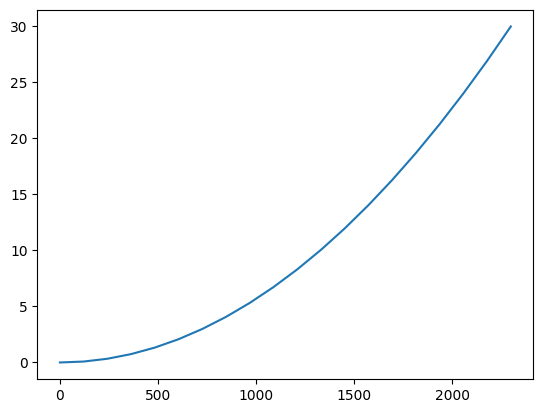

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [-2.985e-11 -2.985e-11 ...  4.936e-28  6.514e-28]
       x: [ 1.344e+05  1.346e+05 ... -3.183e-70 -6.197e-67]
  method: hybr
    nfev: 491
    fjac: [[-7.063e-23 -9.076e-23 ... -1.650e-33  7.425e-34]
           [ 6.256e-18  2.158e-17 ...  4.831e-30 -6.687e-30]
           ...
           [ 0.000e+00  0.000e+00 ... -1.497e-75  1.843e-74]
           [ 0.000e+00  0.000e+00 ... -2.916e-72  3.588e-71]]
       r: [-2.590e+32 -3.681e+32 ... -2.453e-18  1.000e+00]
     qtf: [-3.503e-01 -9.383e-01 ...  9.632e-89  1.875e-85]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]
# x0_,z0_=q0[:node_N],q0[4*node_N:5*node_N]

In [105]:
x0_=x0_-x0_[0]

In [106]:
# q0=root_.x

In [107]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0_

In [108]:
q0

array([ 0.00000000e+00,  1.20965559e+02,  2.41931119e+02,  3.62896678e+02,
        4.83862238e+02,  6.04827797e+02,  7.25793357e+02,  8.46758916e+02,
        9.67724476e+02,  1.08869004e+03,  1.20965559e+03,  1.33062115e+03,
        1.45158671e+03,  1.57255227e+03,  1.69351783e+03,  1.81448339e+03,
        1.93544895e+03,  2.05641451e+03,  2.17738007e+03,  2.29834563e+03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

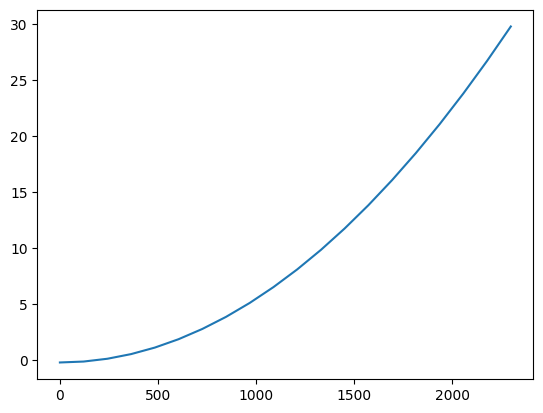

In [109]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [110]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [111]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [112]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [113]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [114]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [115]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [116]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [117]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [118]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [119]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [120]:
fors

array([[-1.51083061e+03,  1.27142468e+01, -1.69792202e+01],
       [ 2.52475729e-08, -1.49855168e-07,  1.22895472e-08],
       [-5.37984306e-08, -8.10987331e-08, -5.35874278e-09],
       [-6.03467925e-08,  5.12952571e-08,  1.20235200e-09],
       [ 2.99885869e-07,  7.34216883e-08,  1.54768713e-08],
       [-1.86264515e-07, -1.02598278e-07,  1.80079951e-08],
       [ 6.79865479e-08,  2.80560926e-08, -1.33732101e-07],
       [-6.33299351e-08, -1.38510399e-08, -1.08360837e-07],
       [-9.31322575e-09,  4.86033969e-08, -2.49710865e-08],
       [ 1.49011612e-07,  5.29107638e-08,  7.40983523e-08],
       [ 7.45058060e-09, -9.01200110e-08,  9.23755579e-08],
       [-1.69500709e-07,  1.07055840e-08,  2.39524525e-08],
       [ 1.11758709e-07, -7.53789209e-09, -2.27591954e-08],
       [ 5.96046448e-08, -6.05359674e-09, -2.21189111e-08],
       [-1.49011612e-07, -2.59024091e-09, -1.86264515e-09],
       [ 1.62770241e-08,  2.75328595e-09, -2.58910458e-09],
       [ 1.44300648e-07, -1.52366749e-09

### Vessle Simulation

In [121]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [122]:
N*sampleTime

100.0

In [123]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [124]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [125]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

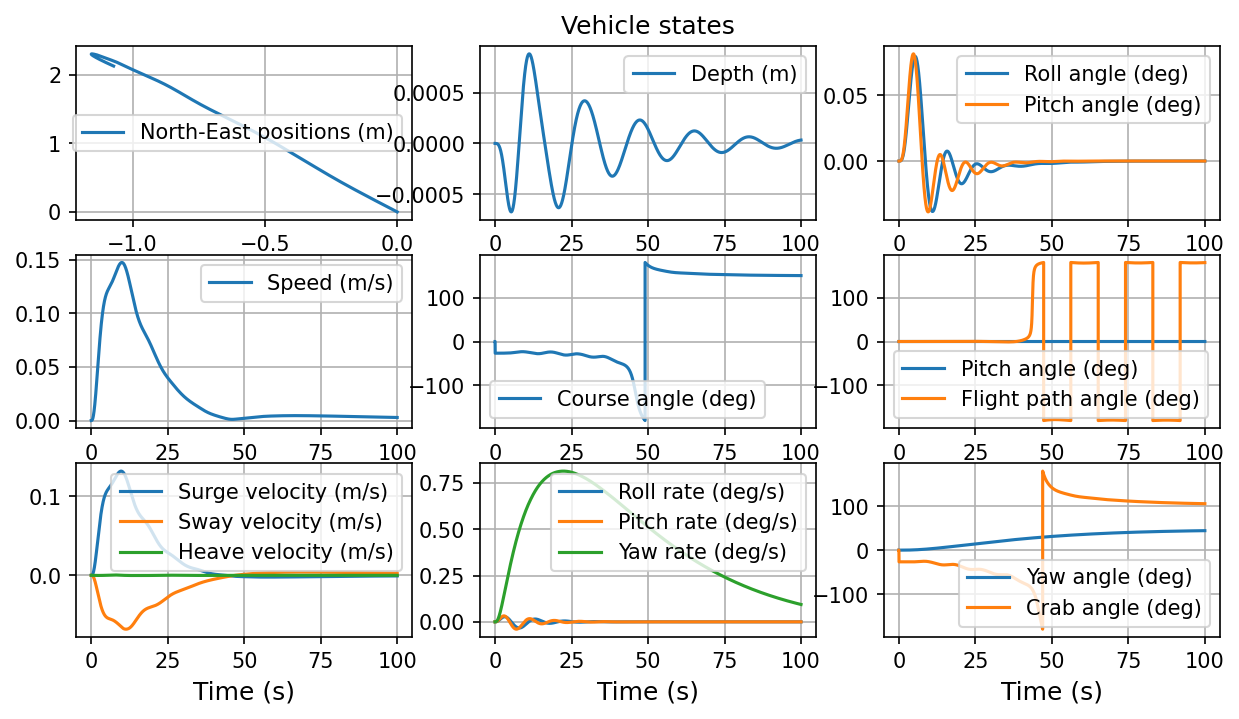

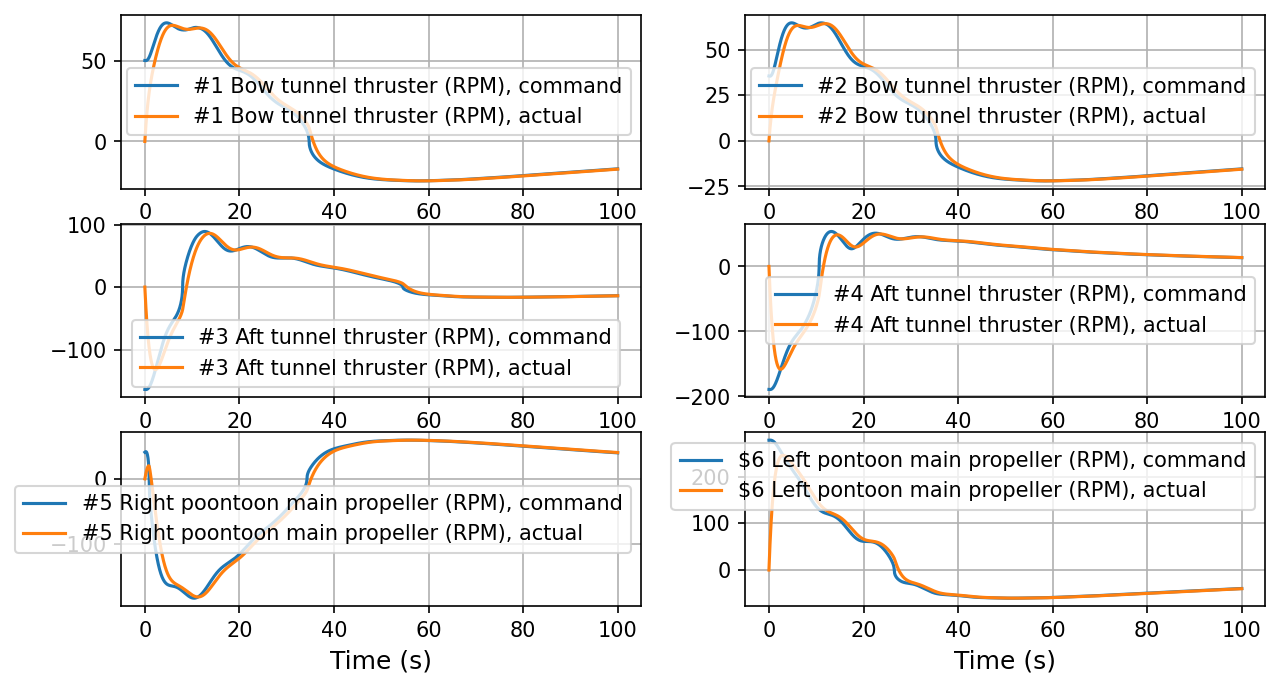

In [126]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [127]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

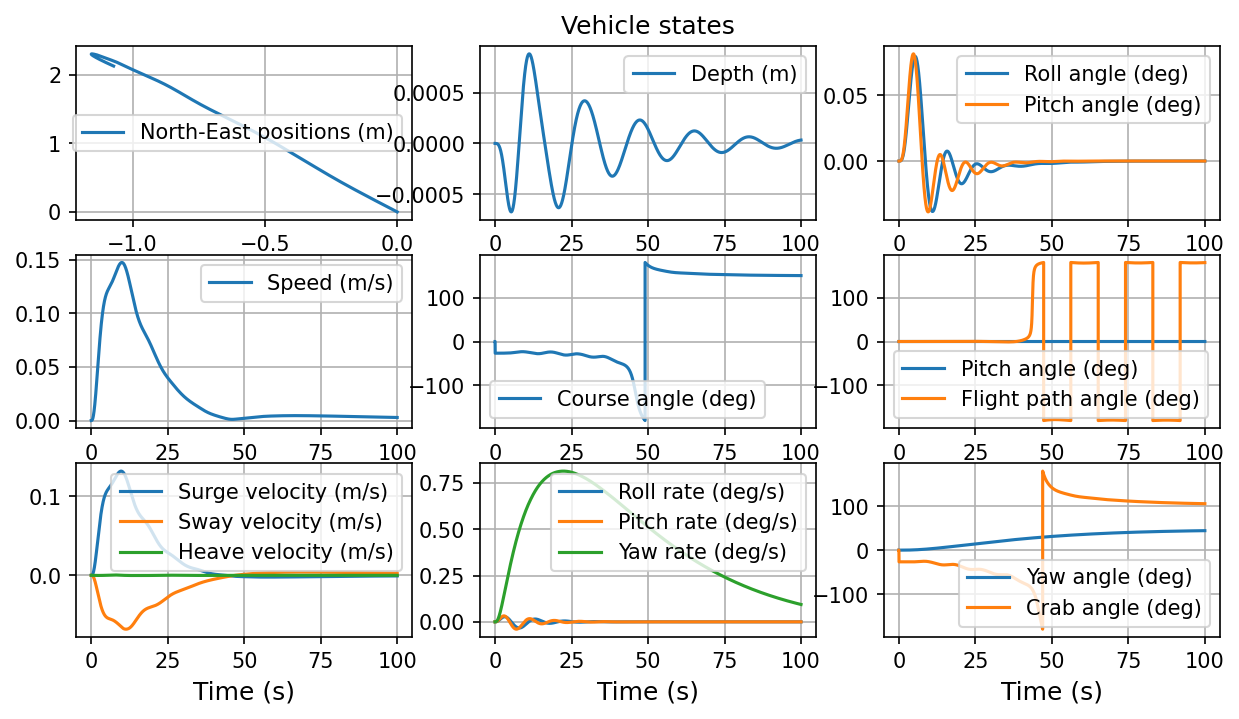

In [128]:
plotVehicleStates(simTime, simData, 3)

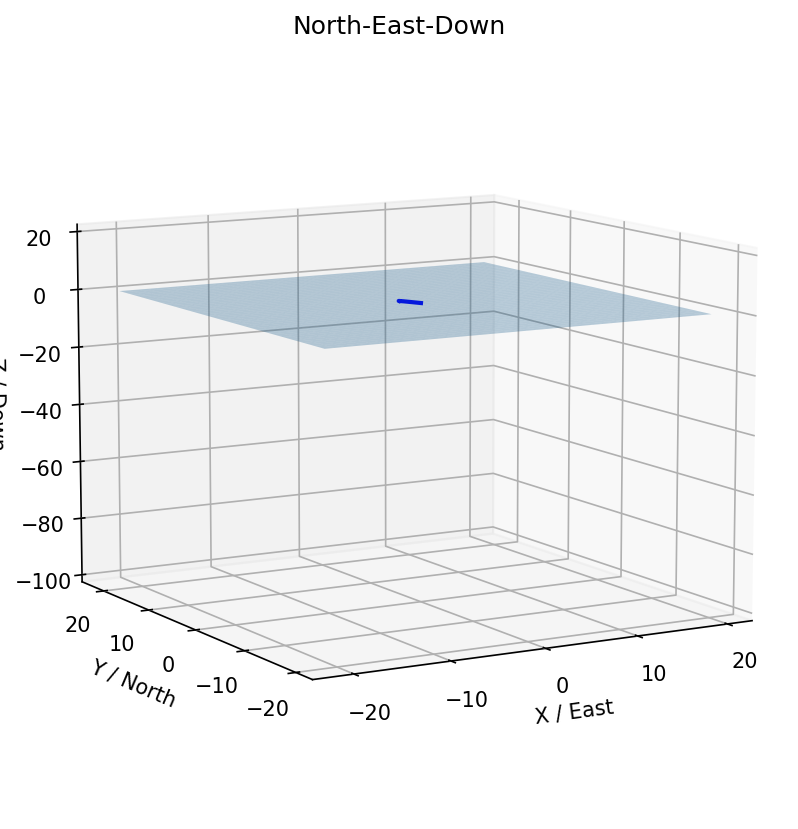

In [129]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [130]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [131]:
idx=1/0.01

In [132]:
idx

100.0

In [133]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [134]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [135]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [136]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [137]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [138]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [139]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       ) 

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [140]:
tspan = (0., 100)
T_ = MyTime()

In [141]:
coefs = [1, 1, 1, 1, 1, 1]

In [142]:
q0

array([ 0.00000000e+00,  1.20965559e+02,  2.41931119e+02,  3.62896678e+02,
        4.83862238e+02,  6.04827797e+02,  7.25793357e+02,  8.46758916e+02,
        9.67724476e+02,  1.08869004e+03,  1.20965559e+03,  1.33062115e+03,
        1.45158671e+03,  1.57255227e+03,  1.69351783e+03,  1.81448339e+03,
        1.93544895e+03,  2.05641451e+03,  2.17738007e+03,  2.29834563e+03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [143]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.0023460753759676927  Iteration wall clock time:  0:00:00.658202
Physical time:  1.1852678025766379  Iteration wall clock time:  0:00:04.536512
Physical time:  2.2514819003731024  Iteration wall clock time:  0:00:07.043745
Physical time:  3.03083433179989  Iteration wall clock time:  0:00:05.756876
Physical time:  4.042079848593521  Iteration wall clock time:  0:00:04.085157
Physical time:  5.01783067468531  Iteration wall clock time:  0:00:04.903130
Physical time:  6.026173399026477  Iteration wall clock time:  0:00:04.207574
Physical time:  7.047852695102695  Iteration wall clock time:  0:00:04.170272
Physical time:  8.020591465090574  Iteration wall clock time:  0:00:03.553736
Physical time:  9.20236922705426  Iteration wall clock time:  0:00:03.959855
Physical time:  10.127197907301955  Iteration wall clock time:  0:00:03.759704
Physical time:  11.260056358564077  Iteration wall clock time:  0:00:03.020581
Physical time:  12.021101079545632  Iteration wall clock ti

### Results

In [144]:
fin=us

In [145]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.975e-02 ...  9.809e+01  1.000e+02]
        y: [[ 0.000e+00  1.604e-11 ...  2.556e+00  2.611e+00]
            [ 1.210e+02  1.210e+02 ...  1.210e+02  1.210e+02]
            ...
            [ 0.000e+00  2.953e-06 ...  3.437e-05  3.437e-05]
            [ 0.000e+00  3.117e-06 ...  3.611e-05  3.622e-05]]
      sol: None
 t_events: None
 y_events: None
     nfev: 356
     njev: 0
      nlu: 0

In [146]:
t=fin.t

In [147]:
fin=fin.y.T

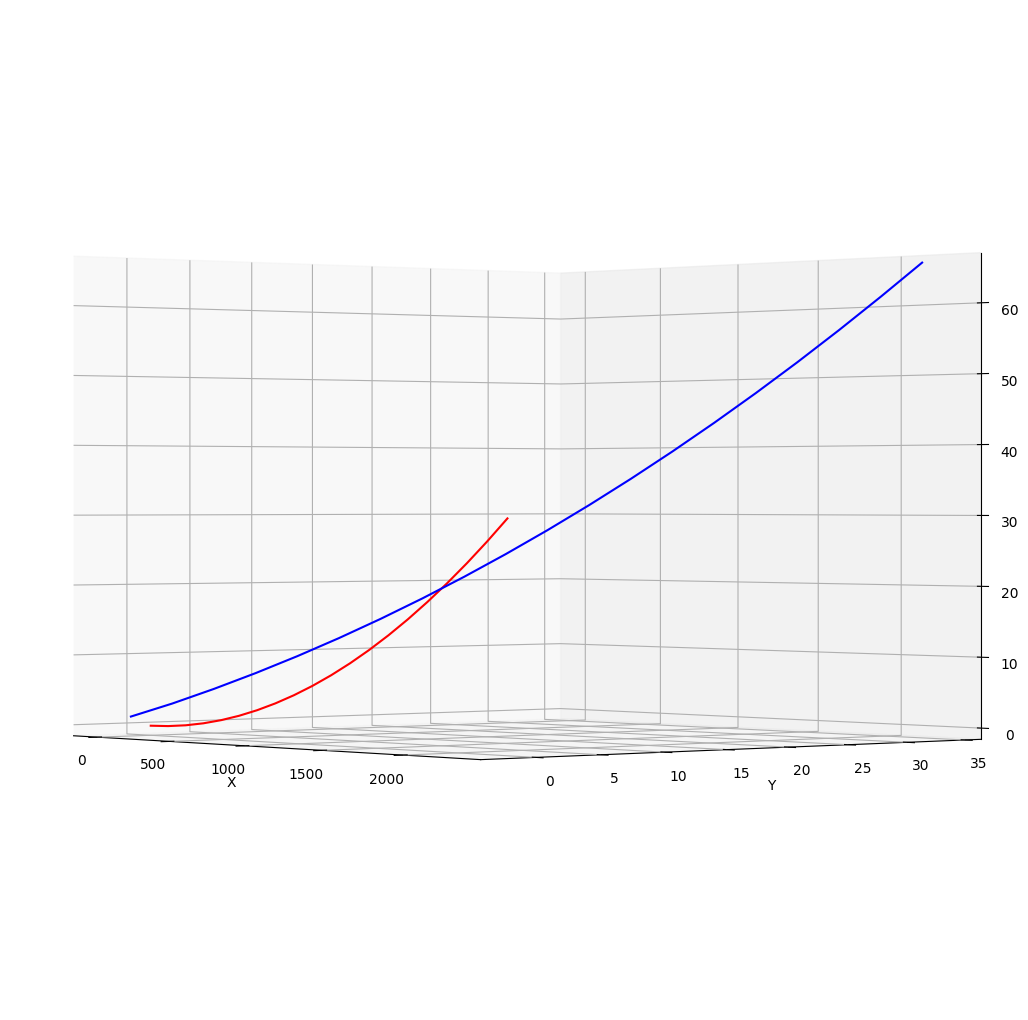

In [148]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-40)
plt.show()

In [149]:
X,Y,Z

(array([   2.61130768,  120.96519036,  241.93037542,  362.89556025,
         483.86074485,  604.82592923,  725.79111338,  846.7562973 ,
         967.72148099, 1088.68666444, 1209.65184767, 1330.61703067,
        1451.58221343, 1572.54739595, 1693.51257824, 1814.4777603 ,
        1935.44294212, 2056.40812369, 2177.37330504, 2295.712444  ]),
 array([-1.58084463,  0.32011951,  2.22305616,  4.1212944 ,  6.01467845,
         7.90320189,  9.78688543, 11.66575732, 13.53984836, 15.40919034,
        17.27381531, 19.13375538, 20.98904252, 22.83970853, 24.68578497,
        26.52730315, 28.36429413, 30.19678867, 32.02481728, 33.84465518]),
 array([ 1.20177821,  3.07483946,  5.18584623,  7.45802209,  9.89148538,
        12.48629608, 15.24249861, 18.16013222, 21.23923402, 24.47984018,
        27.88198637, 31.44570796, 35.1710402 , 39.05801821, 43.1066771 ,
        47.31705193, 51.68917775, 56.22308963, 60.91882265, 65.70268742]))

In [150]:
X0,Y0,Z0

(array([   0.        ,  120.9655595 ,  241.93111899,  362.89667849,
         483.86223798,  604.82779748,  725.79335697,  846.75891647,
         967.72447596, 1088.69003546, 1209.65559495, 1330.62115445,
        1451.58671394, 1572.55227344, 1693.51783294, 1814.48339243,
        1935.44895193, 2056.41451142, 2177.38007092, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([-0.20772757, -0.12465809,  0.12455051,  0.53989871,  1.12138728,
         1.86901732,  2.78279025,  3.86270778,  5.10877196,  6.52098513,
         8.09934995,  9.84386942, 11.7545468 , 13.83138572, 16.07439009,
        18.48356413, 21.0589124 , 23.80043975, 26.70815135, 29.78205269]))

In [151]:
us=fin.T

In [152]:
us.shape

(240, 56)

In [153]:
12*50

600

In [154]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00, -6.34630962e-14, -1.60293828e-11, -7.47679517e-11,
       -1.64456580e-10, -2.77116323e-10, -4.01898482e-10, -5.34147069e-10,
       -6.72513770e-10, -8.17019183e-10, -9.68146620e-10, -1.12645699e-09,
       -1.29241253e-09, -1.46629320e-09, -1.64819055e-09, -1.83806984e-09,
       -2.03591460e-09, -2.24191717e-09, -2.45666995e-09, -2.68132625e-09,
       -2.91771703e-09, -3.16843226e-09, -3.43684972e-09, -3.72704153e-09,
       -4.04340937e-09, -4.38987358e-09, -4.76899074e-09, -5.18223001e-09,
       -5.63245167e-09, -6.12742233e-09, -6.68165212e-09, -7.31299838e-09,
       -8.03315832e-09, -8.85331512e-09, -9.80439303e-09, -1.08929024e-08,
       -1.20181933e-08, -1.30704887e-08, -1.40585160e-08, -1.50714235e-08,
       -1.61767961e-08, -1.73397569e-08, -1.84484661e-08, -1.94576516e-08,
       -2.04391375e-08, -2.14955005e-08, -2.26488551e-08, -2.38000523e-08,
       -2.48476746e-08, -2.58186562e-08, -2.68252672e-08, -2.79433095e-08,
       -2.91206326e-08, -

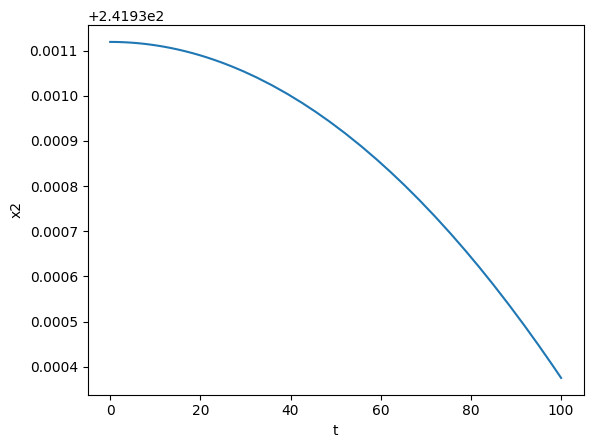

In [155]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

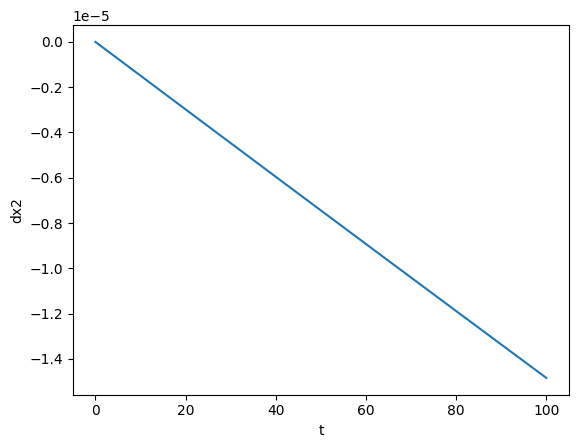

In [156]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

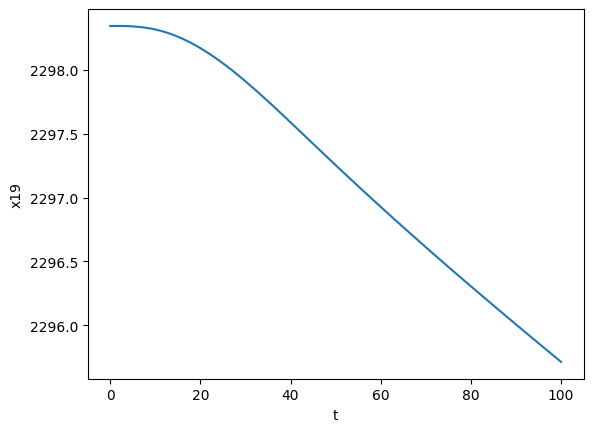

In [157]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

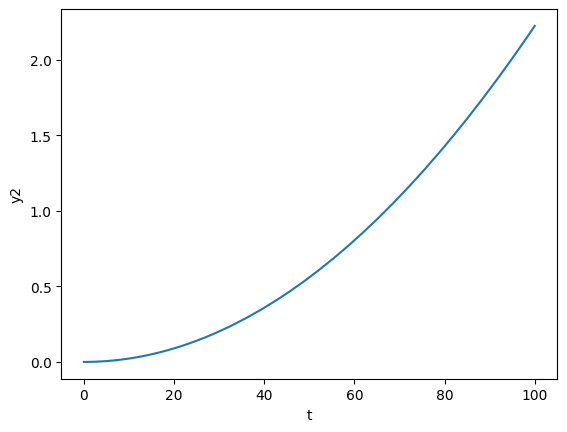

In [158]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

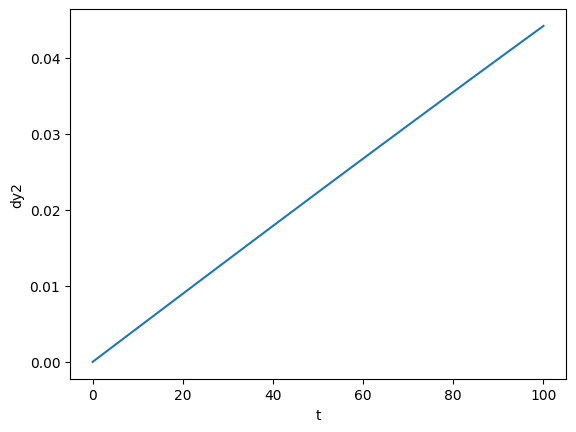

In [159]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

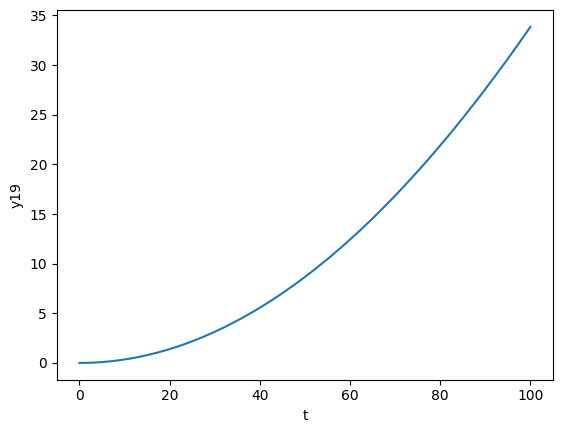

In [160]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

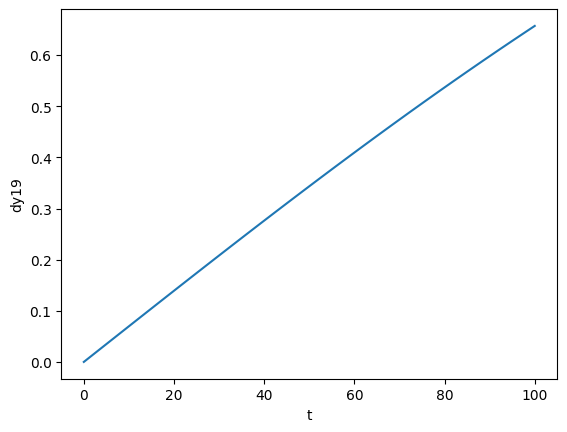

In [161]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

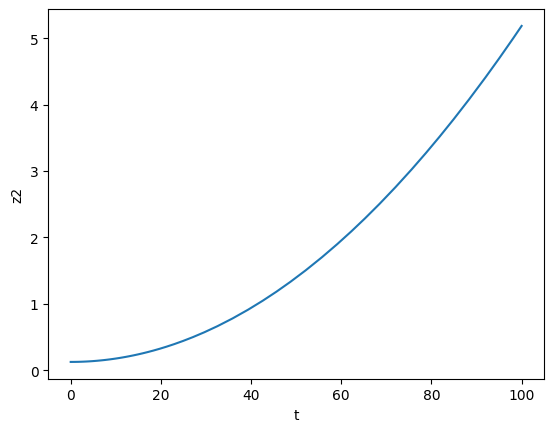

In [162]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

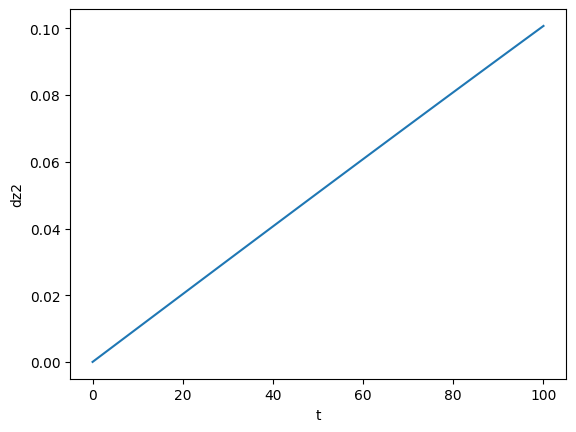

In [163]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

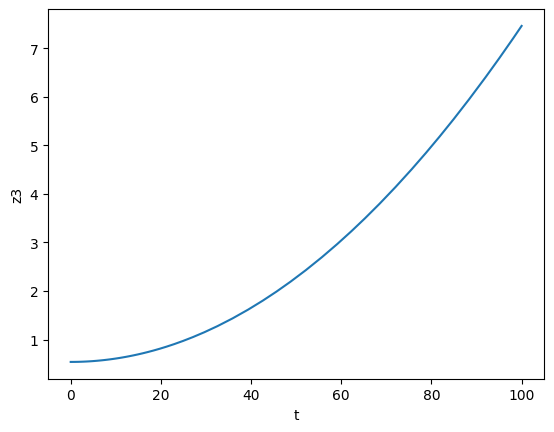

In [164]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

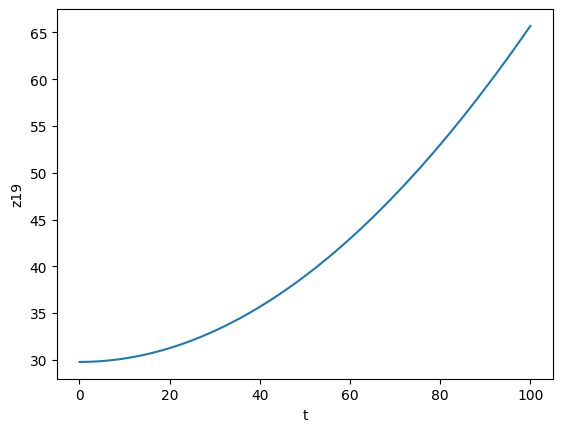

In [165]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

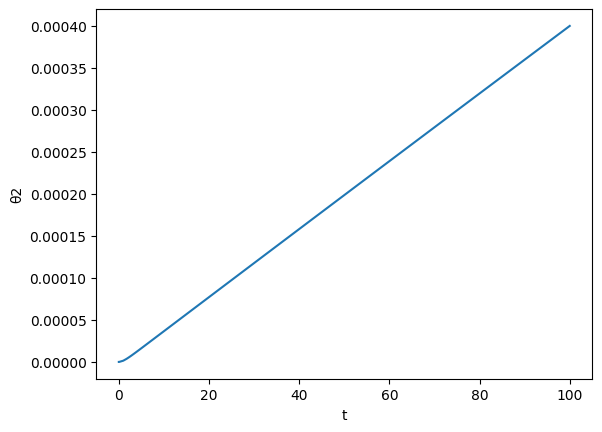

In [166]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

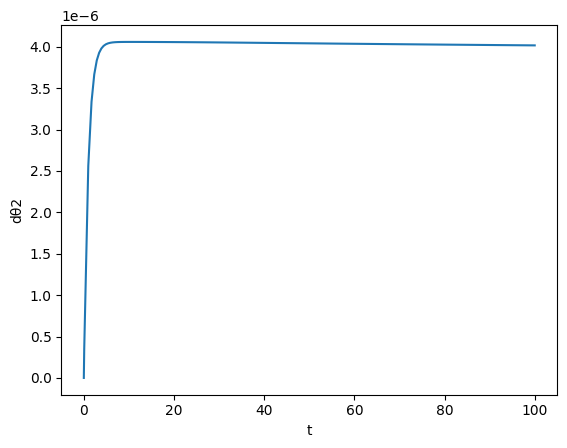

In [167]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

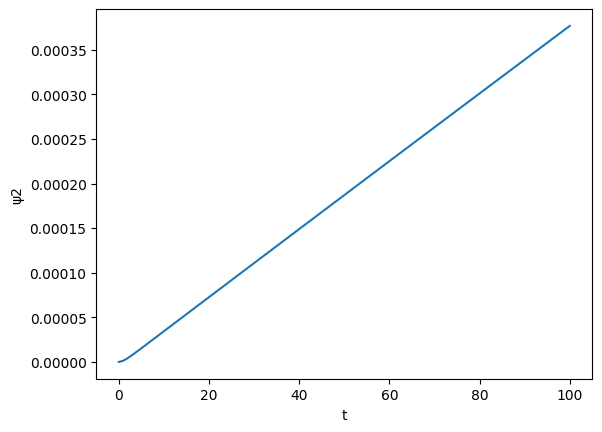

In [168]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

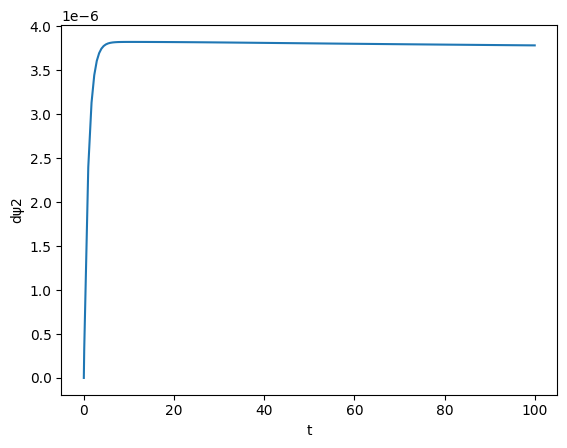

In [169]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

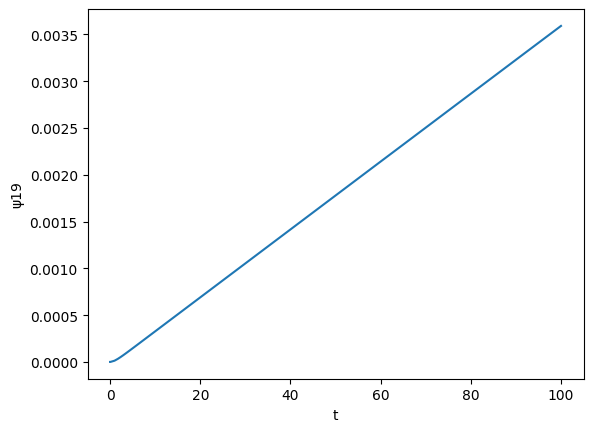

In [170]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()